In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# import torchvision.transforms as transforms
import torchsummary
from tqdm import tqdm

In [34]:
# 1) GPU？
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# <1> 数据预处理
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor()  ])

dataset_path = r"/mnt/workspace/data/ImageNet-10"
# <2> 加载MNIST数据集
dataset = torchvision.datasets.ImageFolder(root= dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))  # 训练集占80%，1,300张*0.8=1040张
test_size = len(dataset) - train_size # 测试集占20%，1,300张-1040张=260张
torch.manual_seed(42)  # 为了保证每次划分的数据集一致
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=4)

Using cuda device


In [36]:
# <3> 定义AlexNet模型
alexnet = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),  nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),           nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),          nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),          nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),          nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096),                                  nn.ReLU(),
    nn.Dropout(p=0.5),  # 防止过拟合，丢弃概率为50%
    nn.Linear(4096, 4096),                                  nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10),
).to(device)  # 2) 将模型加载到GPU上

# torchsummary
torchsummary.summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         884,992
             ReLU-12          [-1, 256, 12, 12]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
          Flatten-14                 [-

In [37]:
# <4> 损失函数
criterion = nn.CrossEntropyLoss()

# <5> 优化器
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

In [38]:
# <6> 自定义计算准确率函数
def test(model, testloader): 
    # <6-1> 进入评估模式
    model.eval()

    # <6-2> 计算输出
    correct = total = 0
    with torch.no_grad():   # 关闭梯度计算
        # 从测试集中一批一批地取数据, 每批64个, 一共取260/64=4次+1次
        for images, labels in testloader: 

            # 4) 将测试数据加载到GPU上
            images, labels = images.to(device), labels.to(device)

            # 计算预测值
            outputs = model(images)

            # <6-3> 计算准确率
            # 按行(=1)取最大值，返回最大值、最大值的索引(预测结果)
            _, predicted = torch.max(outputs.data, 1)

            # 预测值与真实值比较后, 再求和
            correct += (predicted == labels).sum().item()
            # 测试集总数
            total += labels.size(0)

    # 准确率
    accuracy = correct / total

    # 返回：准确率
    return accuracy

In [39]:
# <7> 训练模型
# 初始化训练过程中的指标：训练精度、测试精度、损失，用于绘图
train_acc_history, test_acc_history, loss_history = [], [], []

for epoch in tqdm(range(10)):  # 训练10个epoch
    alexnet.train()
    epoch_loss = 0.0        # 每epoch的损失
    running_loss = 0.0      # 每64批次batch的损失

    # 从0开始计数，每次取一个batch，一共取1040/64=16.25次
    for i, data in enumerate(trainloader, 0):
        X_train, y_train = data

        # 3) 将训练数据加载到GPU上
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = alexnet(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        running_loss += loss.item()

        # 每100个batch打印一次损失
        if i % 100 == 99:  
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.8f}")
            running_loss = 0.0

    # 更新绘图指标
    train_acc_history.append(test(alexnet, trainloader))
    test_acc_history.append(test(alexnet, testloader))
    loss_history.append(epoch_loss / len(trainloader))
    print(f"Epoch {epoch + 1} loss: {epoch_loss / len(trainloader):.8f}, train accuracy: {train_acc_history[-1]:.3%}, test accuracy: {test_acc_history[-1]:.3%}")

# 清空CUDA缓存
torch.cuda.empty_cache()

# 打印CUDA内存使用情况
print(f"CUDA memory allocated: {torch.cuda.memory_allocated(device) / 1024**2:.0f} MB")

print("Finished Training")

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1, Batch 100] loss: 2.10974829


 10%|█         | 1/10 [00:27<04:08, 27.59s/it]

Epoch 1 loss: 2.00587080, train accuracy: 39.254%, test accuracy: 38.547%
[Epoch 2, Batch 100] loss: 1.56684676


 20%|██        | 2/10 [00:54<03:39, 27.48s/it]

Epoch 2 loss: 1.47075960, train accuracy: 59.131%, test accuracy: 60.607%
[Epoch 3, Batch 100] loss: 1.18537331


 30%|███       | 3/10 [01:23<03:16, 28.09s/it]

Epoch 3 loss: 1.15169829, train accuracy: 65.725%, test accuracy: 66.026%
[Epoch 4, Batch 100] loss: 0.98730467


 40%|████      | 4/10 [01:51<02:46, 27.81s/it]

Epoch 4 loss: 0.96116293, train accuracy: 73.030%, test accuracy: 71.176%
[Epoch 5, Batch 100] loss: 0.85224776


 50%|█████     | 5/10 [02:18<02:18, 27.72s/it]

Epoch 5 loss: 0.82440495, train accuracy: 77.240%, test accuracy: 73.943%
[Epoch 6, Batch 100] loss: 0.74308339


 60%|██████    | 6/10 [02:46<01:51, 27.75s/it]

Epoch 6 loss: 0.72488208, train accuracy: 73.010%, test accuracy: 70.484%
[Epoch 7, Batch 100] loss: 0.68351995


 70%|███████   | 7/10 [03:14<01:23, 27.78s/it]

Epoch 7 loss: 0.65968618, train accuracy: 80.383%, test accuracy: 74.865%
[Epoch 8, Batch 100] loss: 0.58186396


 80%|████████  | 8/10 [03:41<00:55, 27.70s/it]

Epoch 8 loss: 0.59161961, train accuracy: 82.968%, test accuracy: 77.095%
[Epoch 9, Batch 100] loss: 0.54470430


 90%|█████████ | 9/10 [04:09<00:27, 27.68s/it]

Epoch 9 loss: 0.52906407, train accuracy: 85.342%, test accuracy: 78.862%
[Epoch 10, Batch 100] loss: 0.48037042


100%|██████████| 10/10 [04:43<00:00, 28.36s/it]

Epoch 10 loss: 0.48194971, train accuracy: 85.015%, test accuracy: 76.441%
CUDA memory allocated: 828 MB
Finished Training


In [49]:
torch.save(alexnet.state_dict(), "/mnt/workspace/alexnet_weights.pth")

findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not

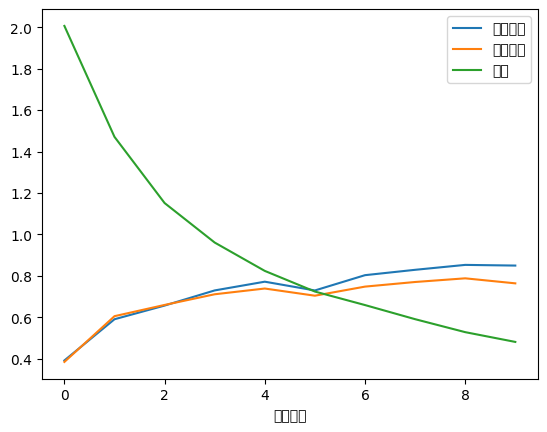

最终训练精度: 85.02%
最终测试精度: 76.44%


In [47]:
# <8> 绘制训练过程中的指标
import matplotlib.pyplot as plt
from matplotlib import rcParams  # 设置全局参数，为了设置中文字体


# 定义绘制函数
def draw_plot(train_acc_history, test_acc_history, loss_history):
    rcParams["font.family"] = "simHei"  # 设置中文黑体字
    plt.figure()
    plt.plot(train_acc_history, label="训练精度")
    plt.plot(test_acc_history, label="测试精度")
    plt.plot(loss_history, label="损失")
    plt.legend()  # 显示图例
    plt.xlabel("迭代次数")
    plt.show()


draw_plot(train_acc_history, test_acc_history, loss_history)
print(f"最终训练精度: {train_acc_history[-1]:.2%}")
print(f"最终测试精度: {test_acc_history[-1]:.2%}")

In [51]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# 打开图像文件
image_path = "/mnt/workspace/data/鸡.jpg"
image_path_peng = "/mnt/workspace/data/企鹅.jpg"
image = Image.open(image_path)
image_peng = Image.open(image_path_peng)

# 转换图像模式
if image.mode == 'RGBA':
    image = image.convert('RGB')
if image_peng.mode == 'RGBA':  # 修复此处变量名错误
    image_peng = image_peng.convert('RGB')  # 正确转换为企鹅图像的RGB模式

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 处理第一个图像
input_tensor1 = transform(image)
input_batch1 = input_tensor1.unsqueeze(0)  # 添加batch维度 [1, 3, 224, 224]

# 处理第二个图像
input_tensor2 = transform(image_peng)
input_batch2 = input_tensor2.unsqueeze(0)  # 添加batch维度

# 加载模型（使用新式参数）
# 确保加载的是训练后的权重，而不是预训练权重
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet.eval()


# 分别进行预测
with torch.no_grad():
    output1 = alexnet(input_batch1)
    output2 = alexnet(input_batch2)

# 获取并打印结果
_, predicted1 = torch.max(output1, 1)
_, predicted2 = torch.max(output2, 1)
print(f"鸡的预测类别: {predicted1.item()}")
print(f"企鹅的预测类别: {predicted2.item()}")

鸡的预测类别: 8
企鹅的预测类别: 128


In [52]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# 打开图像文件
image_path = "/mnt/workspace/data/鸡.jpg"
image_path_peng = "/mnt/workspace/data/企鹅.jpg"
image = Image.open(image_path)
image_peng = Image.open(image_path_peng)

# 转换图像模式
if image.mode == 'RGBA':
    image = image.convert('RGB')
if image_peng.mode == 'RGBA':  # 修复此处变量名错误
    image_peng = image_peng.convert('RGB')  # 正确转换为企鹅图像的RGB模式

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 处理第一个图像
input_tensor1 = transform(image)
input_batch1 = input_tensor1.unsqueeze(0)  # 添加batch维度 [1, 3, 224, 224]

# 处理第二个图像
input_tensor2 = transform(image_peng)
input_batch2 = input_tensor2.unsqueeze(0)  # 添加batch维度

# 加载模型（使用新式参数）
# 确保加载的是训练后的权重，而不是预训练权重
# 确保加载的是训练后的权重，而不是预训练权重
alexnet = models.alexnet()
alexnet.load_state_dict(torch.load("/mnt/workspace/alexnet_weights.pth"))
alexnet.eval()


# 分别进行预测
with torch.no_grad():
    output1 = alexnet(input_batch1)
    output2 = alexnet(input_batch2)

# 获取并打印结果
_, predicted1 = torch.max(output1, 1)
_, predicted2 = torch.max(output2, 1)
print(f"鸡的预测类别: {predicted1.item()}")
print(f"企鹅的预测类别: {predicted2.item()}")

鸡的预测类别: 590
企鹅的预测类别: 651
